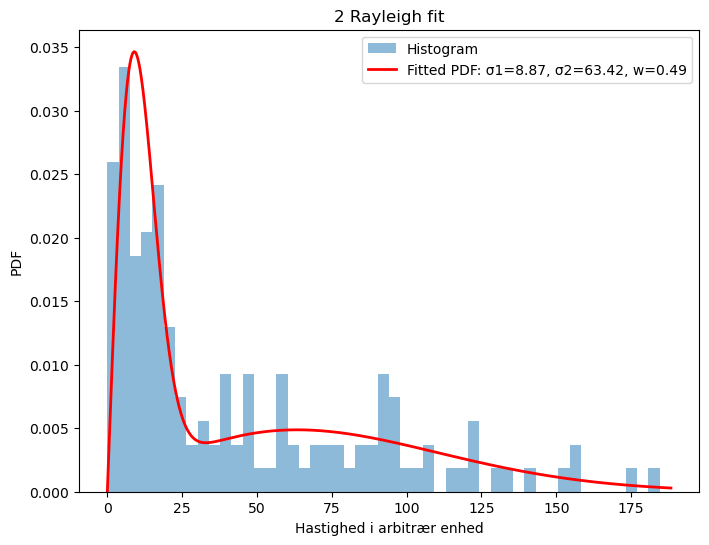

(np.float64(8.86956698608692),
 np.float64(63.423406840462924),
 np.float64(0.49020908973582306))

In [76]:
def double_rayleigh(path,p0,sfs=10,bins=40,minlike=0.8,percentile=99,plotting=True):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.optimize import minimize
    data=np.genfromtxt(path,delimiter=",",skip_header=1)

    nlike=data[:,3]
    ellike=data[:,6]
    erlike=data[:,9]
    sllike=data[:,12]
    srlike=data[:,15]
    tlike=data[:,18]

    mask = (tlike>minlike) & (srlike>minlike) & (sllike>minlike) & (erlike>minlike) & (ellike>minlike) & (nlike>minlike)

    slx=data[:,10][mask]
    sly=data[:,11][mask]
    srx=data[:,13][mask]
    sry=data[:,14][mask]
    tx=data[:,16][mask]
    ty=data[:,17][mask]

    Smidx=slx+(srx-slx)/2
    Smidy=sly+(sry-sly)/2
    midx=tx+(Smidx-tx)/2
    midy=ty+(Smidy-ty)/2

    n = len(midx) % sfs
    if n != 0:
        x_trunc = midx[:-n]
        y_trunc = midy[:-n]
    else:
        x_trunc = midx
        y_trunc = midy

    x_blocks = x_trunc.reshape(-1, sfs)
    y_blocks = y_trunc.reshape(-1, sfs)

    speed = np.abs(np.sqrt((x_blocks[:,-1] - x_blocks[:,0])**2 + (y_blocks[:,-1] - y_blocks[:,0])**2))

    def weighted_rayleigh_pdf(x, sigma1, sigma2, w):
        r1 = (x / sigma1**2) * np.exp(-x**2/(2*sigma1**2))
        r2 = (x / sigma2**2) * np.exp(-x**2/(2*sigma2**2))
        return w*r1 + (1-w)*r2

    def neg_log_likelihood(params, data):
        sigma1, sigma2, w = params
        pdf_vals = weighted_rayleigh_pdf(data, sigma1, sigma2, w)
        return -np.sum(np.log(pdf_vals + 1e-12))

    res = minimize(neg_log_likelihood, x0=p0, args=(speed,),
                bounds=[(1e-6, None),(1e-6, None),(1e-3, 1-1e-3)])

    sigma1, sigma2, weight = res.x
    if plotting==True:
        plt.figure(figsize=(8,6))
        upper = np.percentile(speed, percentile)
        plt.hist(speed, bins=bins, range=(0, upper), density=True, alpha=0.5, color='C0', label="Histogram")
        X = np.linspace(0, upper, 1000)
        Y = weighted_rayleigh_pdf(X, sigma1, sigma2, weight)
        plt.plot(X, Y, 'r', lw=2, label=f"Fitted PDF: σ1={sigma1:.2f}, σ2={sigma2:.2f}, w={weight:.2f}")
        plt.legend()
        plt.xlabel("Hastighed i arbitrær enhed")
        plt.ylabel("PDF")
        plt.title("2 Rayleigh fit")
        plt.show()
    return sigma1, sigma2, weight

double_rayleigh("mus.csv", p0=[1, 2, 0.5], sfs=20, bins=50, minlike=0.8, percentile=99, plotting=True)